In [19]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [20]:
!pip install tensorflow==2.19



Installing collected packages: jaxlib, tensorflow

In [21]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-11-02 01:51:40--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.15.193.128, 52.216.53.208, 52.217.233.208, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.15.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  16.2MB/s    in 0.8s    

2025-11-02 01:51:42 (16.2 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Inspecting the data of the Jena weather dataset**



In [23]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**



In [24]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]



**Plotting the temperature timeseries**



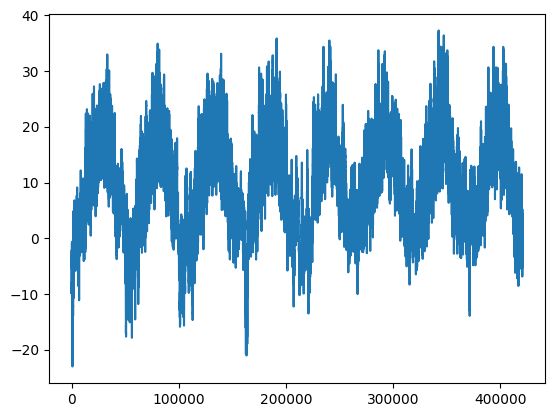

In [25]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**



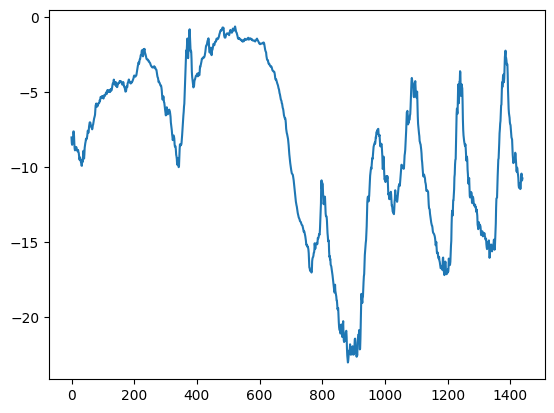

In [26]:
plt.plot(range(1440), temperature[:1440])


**Computing the number of samples we'll use for each data split**



In [27]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


# **Preparing the data**

**Normalizing the data**




In [29]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [30]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**



In [31]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**



In [32]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


**A common-sense, non-machine-learning baseline**

Computing the common-sense baseline MAE



In [33]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 10.28
Test MAE: 10.40


# **Model 1**

**Let's try a basic machine-learning model**

Training and evaluating a densely connected model





In [36]:
from tensorflow import keras
from tensorflow.keras import layers

# Example input shape (adjust according to dataset structure)
sequence_length = 10  # Adjust according to dataset
feature_dim = raw_data.shape[-1]  # Ensure raw_data is defined

# Define the model
inputs = keras.Input(shape=(sequence_length, feature_dim))
x = layers.GlobalAveragePooling1D()(inputs)  # Replaces Flatten for sequence data
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,  # Ensure train_dataset is properly formatted
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load and evaluate the best model
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
print(f"Validation MAE: {min(history.history['val_mae']):.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 57s 69ms/step - loss: 89.0983 - mae: 7.4799 - val_loss: 21.5474 - val_mae: 3.6576
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 56s 68ms/step - loss: 22.5281 - mae: 3.7985 - val_loss: 20.4136 - val_mae: 3.5706
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 54s 65ms/step - loss: 22.0442 - mae: 3.7544 - val_loss: 20.4217 - val_mae: 3.5739
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 56s 68ms/step - loss: 21.8827 - mae: 3.7440 - val_loss: 20.5266 - val_mae: 3.5802
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 55s 67ms/step - loss: 21.7486 - mae: 3.7327 - val_loss: 20.5673 - val_mae: 3.5855
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 55s 67ms/step - loss: 21.6289 - mae: 3.7224 - val_loss: 20.6484 - val_mae: 3.5862
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 57s 69ms/step - loss: 21.5100 - mae: 3.7116 - val_loss: 20.5027 - val_mae: 3.5728
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 55s 67ms/step - loss: 21.4158 - mae: 3.7022 - val_loss: 20.5154 - val_mae: 3.5665
Epoch 9/10
819/819 ━━━━━

**Plotting results**



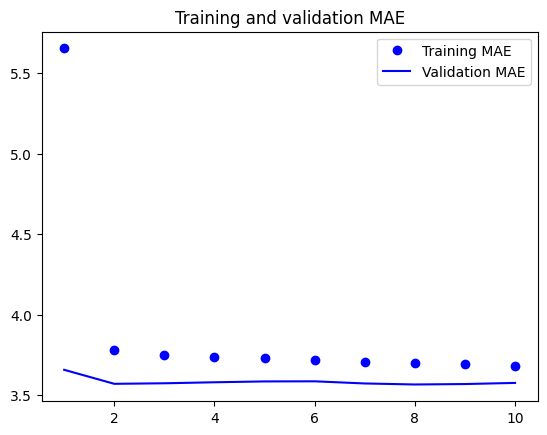

In [37]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()


# **Model 2**

LSTM model with three layers and 8 units







In [38]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# Add three LSTM layers with 8 units each
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8, return_sequences=True)(x)
x = layers.LSTM(8)(x)

# Output layer
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_lstm.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 225ms/step - loss: 0.1173 - mae: 0.2752 - val_loss: 0.0770 - val_mae: 0.2323
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0811 - mae: 0.2461 - val_loss: 0.0769 - val_mae: 0.2325
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0811 - mae: 0.2461 - val_loss: 0.0769 - val_mae: 0.2326
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0811 - mae: 0.2461 - val_loss: 0.0768 - val_mae: 0.2327
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0810 - mae: 0.2462 - val_loss: 0.0768 - val_mae: 0.2327
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0810 - mae: 0.2462 - val_loss: 0.0768 - val_mae: 0.2327
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0810 - mae: 0.2462 - val_loss: 0.0768 - val_mae: 0.2327
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0809 - mae: 0.2462 - val_loss: 0.0767 - val_mae: 0.2327
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0

**Plotting results**



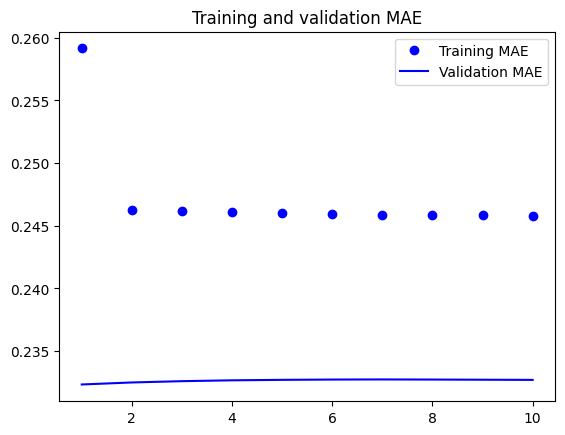

In [39]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# **Model 3**

LSTM model with three layers and 16 units





In [40]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# Add three LSTM layers with 16 units each
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16, return_sequences=True)(x)
x = layers.LSTM(16)(x)

# Output layer
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)


# Load the best model and evaluate
model = keras.models.load_model("jena_lstm.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.2070 - mae: 0.3680 - val_loss: 0.0843 - val_mae: 0.2486
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0809 - mae: 0.2448 - val_loss: 0.0841 - val_mae: 0.2484
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0803 - mae: 0.2442 - val_loss: 0.0840 - val_mae: 0.2484
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0796 - mae: 0.2434 - val_loss: 0.0841 - val_mae: 0.2483
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0792 - mae: 0.2429 - val_loss: 0.0841 - val_mae: 0.2483
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0789 - mae: 0.2425 - val_loss: 0.0841 - val_mae: 0.2483
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0787 - mae: 0.2422 - val_loss: 0.0842 - val_mae: 0.2483
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0785 - mae: 0.2420 - val_loss: 0.0842 - val_mae: 0.2483
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.078

**Plotting results**



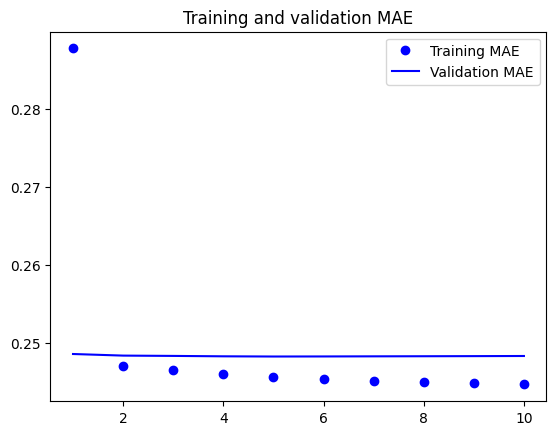

In [41]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# **Model 4**

LSTM model with three layers and 32 units




In [42]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# Add three LSTM layers with 32 units each
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32, return_sequences=True)(x)
x = layers.LSTM(32)(x)

# Output layer
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_lstm.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - loss: 0.1429 - mae: 0.3121 - val_loss: 0.0823 - val_mae: 0.2518
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0841 - mae: 0.2459 - val_loss: 0.0822 - val_mae: 0.2518
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0836 - mae: 0.2455 - val_loss: 0.0822 - val_mae: 0.2518
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0831 - mae: 0.2452 - val_loss: 0.0822 - val_mae: 0.2518
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0828 - mae: 0.2450 - val_loss: 0.0822 - val_mae: 0.2518
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0824 - mae: 0.2448 - val_loss: 0.0822 - val_mae: 0.2518
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0822 - mae: 0.2446 - val_loss: 0.0822 - val_mae: 0.2518
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0820 - mae: 0.2444 - val_loss: 0.0822 - val_mae: 0.2518
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.08

**Plotting results**



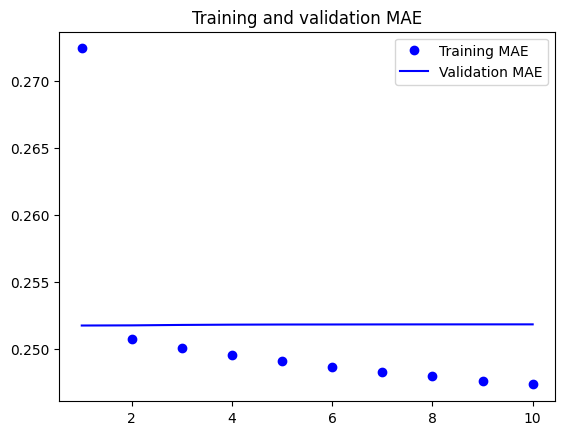

In [43]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# **Model 5**

LSTM model with four layers with 16 units

In [44]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# Add four LSTM layers with 16 units each
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16, return_sequences=True)(x)
x = layers.LSTM(16, return_sequences=True)(x)
x = layers.LSTM(16)(x)

# Output layer
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_lstm.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 0.1636 - mae: 0.3275 - val_loss: 0.0942 - val_mae: 0.2591
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0899 - mae: 0.2601 - val_loss: 0.0948 - val_mae: 0.2595
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0899 - mae: 0.2601 - val_loss: 0.0937 - val_mae: 0.2584
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0895 - mae: 0.2596 - val_loss: 0.0925 - val_mae: 0.2573
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0891 - mae: 0.2591 - val_loss: 0.0915 - val_mae: 0.2565
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0888 - mae: 0.2587 - val_loss: 0.0906 - val_mae: 0.2558
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0885 - mae: 0.2583 - val_loss: 0.0899 - val_mae: 0.2552
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0883 - mae: 0.2581 - val_loss: 0.0892 - val_mae: 0.2547
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.08

**Plotting results**



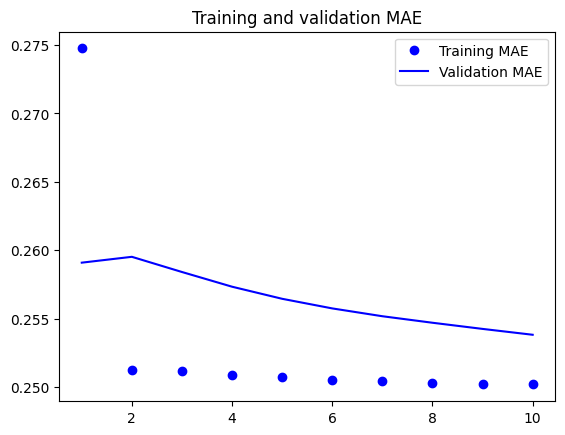

In [45]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# **Model 6**

Using gru three layers and 8 units

In [46]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# Add three GRU layers with 8 units each
x = layers.GRU(8, return_sequences=True)(inputs)
x = layers.GRU(8, return_sequences=True)(x)
x = layers.GRU(8)(x)

# Output layer
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_gru.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.1195 - mae: 0.2885 - val_loss: 0.0887 - val_mae: 0.2519
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0818 - mae: 0.2459 - val_loss: 0.0878 - val_mae: 0.2512
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0814 - mae: 0.2454 - val_loss: 0.0874 - val_mae: 0.2508
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0810 - mae: 0.2449 - val_loss: 0.0870 - val_mae: 0.2506
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0806 - mae: 0.2446 - val_loss: 0.0868 - val_mae: 0.2505
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0804 - mae: 0.2443 - val_loss: 0.0867 - val_mae: 0.2505
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0802 - mae: 0.2441 - val_loss: 0.0866 - val_mae: 0.2505
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0800 - mae: 0.2440 - val_loss: 0.0866 - val_mae: 0.2506
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.07

**Plotting results**



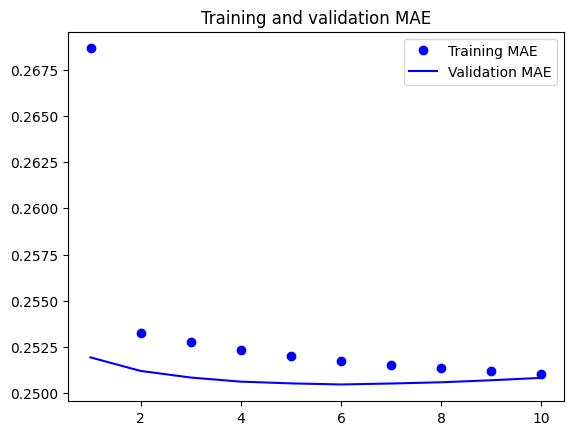

In [47]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# **Model 7**

Using gru three layers and 16 units

In [48]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# Add three GRU layers with 16 units each
x = layers.GRU(16, return_sequences=True)(inputs)
x = layers.GRU(16, return_sequences=True)(x)
x = layers.GRU(16)(x)

# Output layer
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_gru.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - loss: 0.1691 - mae: 0.3320 - val_loss: 0.0865 - val_mae: 0.2484
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0893 - mae: 0.2578 - val_loss: 0.0865 - val_mae: 0.2487
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0890 - mae: 0.2573 - val_loss: 0.0860 - val_mae: 0.2489
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0884 - mae: 0.2566 - val_loss: 0.0856 - val_mae: 0.2490
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0879 - mae: 0.2559 - val_loss: 0.0854 - val_mae: 0.2492
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0875 - mae: 0.2553 - val_loss: 0.0852 - val_mae: 0.2494
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0871 - mae: 0.2548 - val_loss: 0.0850 - val_mae: 0.2495
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0868 - mae: 0.2543 - val_loss: 0.0849 - val_mae: 0.2497
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.08

**Plotting results**



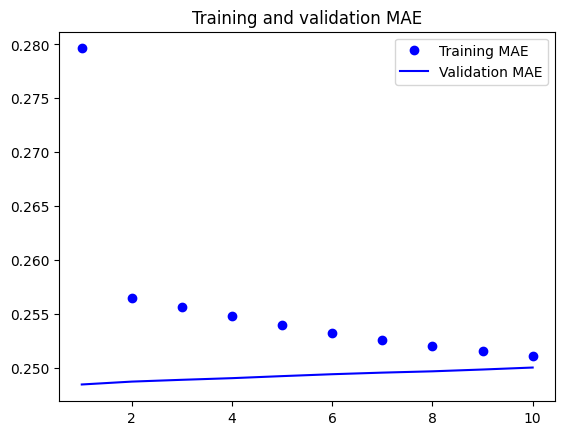

In [49]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# **Model 8**

Using gru with three layers and 32 units

In [50]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# Add three GRU layers with 32 units each
x = layers.GRU(32, return_sequences=True)(inputs)
x = layers.GRU(32, return_sequences=True)(x)
x = layers.GRU(32)(x)

# Output layer
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_gru.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 0.1011 - mae: 0.2674 - val_loss: 0.0809 - val_mae: 0.2422
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0854 - mae: 0.2474 - val_loss: 0.0782 - val_mae: 0.2381
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0856 - mae: 0.2477 - val_loss: 0.0773 - val_mae: 0.2364
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0856 - mae: 0.2478 - val_loss: 0.0769 - val_mae: 0.2357
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0855 - mae: 0.2477 - val_loss: 0.0767 - val_mae: 0.2354
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0853 - mae: 0.2475 - val_loss: 0.0765 - val_mae: 0.2351
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0851 - mae: 0.2472 - val_loss: 0.0764 - val_mae: 0.2350
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0848 - mae: 0.2469 - val_loss: 0.0763 - val_mae: 0.2348
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.084

**Plotting results**



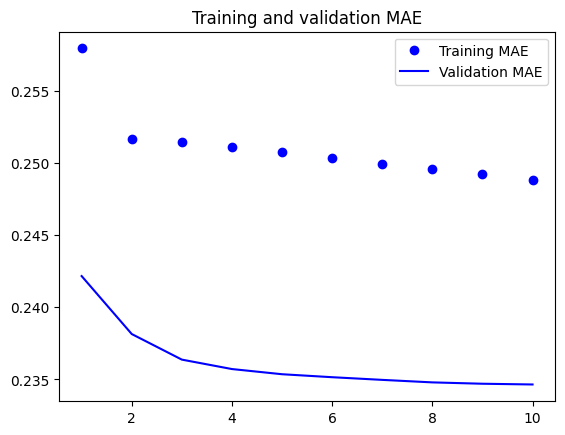

In [51]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# **Model 9**

Using gru four layers and 16 units

In [52]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16, return_sequences=True)(inputs)
x = layers.GRU(16, return_sequences=True)(x)
x = layers.GRU(16, return_sequences=True)(x)
x = layers.GRU(16)(x)
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_gru.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 200ms/step - loss: 0.1818 - mae: 0.3456 - val_loss: 0.0786 - val_mae: 0.2331
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0887 - mae: 0.2587 - val_loss: 0.0784 - val_mae: 0.2331
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0885 - mae: 0.2586 - val_loss: 0.0781 - val_mae: 0.2328
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0881 - mae: 0.2584 - val_loss: 0.0780 - val_mae: 0.2325
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0877 - mae: 0.2582 - val_loss: 0.0779 - val_mae: 0.2323
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0874 - mae: 0.2581 - val_loss: 0.0779 - val_mae: 0.2321
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0872 - mae: 0.2580 - val_loss: 0.0779 - val_mae: 0.2321
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0870 - mae: 0.2579 - val_loss: 0.0779 - val_mae: 0.2321
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0

**Plotting results**



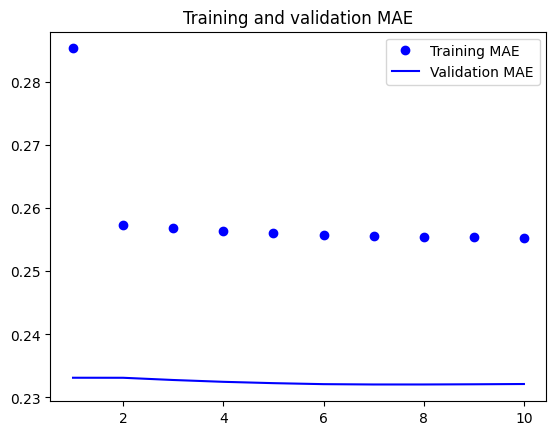

In [53]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()


# **Model 10**

Using 1D Convolution and LSTM

In [54]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))
val_size = int(0.2 * len(raw_data))
test_size = len(raw_data) - (train_size + val_size)

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
# Set return_sequences=True for the first LSTM layer
x = layers.LSTM(32, return_sequences=True)(x)  # Change here
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_cnn_lstm.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_cnn_lstm.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.1212 - mae: 0.2946 - val_loss: 0.0820 - val_mae: 0.2342
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0941 - mae: 0.2680 - val_loss: 0.0799 - val_mae: 0.2330
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0927 - mae: 0.2661 - val_loss: 0.0785 - val_mae: 0.2319
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0916 - mae: 0.2645 - val_loss: 0.0775 - val_mae: 0.2311
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0908 - mae: 0.2633 - val_loss: 0.0769 - val_mae: 0.2306
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0901 - mae: 0.2623 - val_loss: 0.0764 - val_mae: 0.2303
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0896 - mae: 0.2614 - val_loss: 0.0761 - val_mae: 0.2299
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0891 - mae: 0.2606 - val_loss: 0.0758 - val_mae: 0.2295
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.088

**Plotting results**



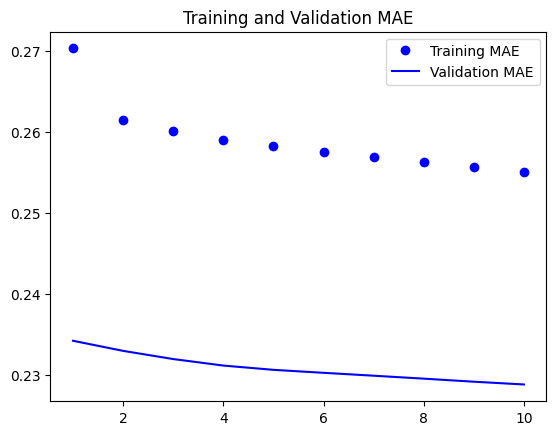

In [55]:
# Plotting MAE like the given example
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

# **Model 11**

Using 1D Convolution and simple RNN

In [56]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = layers.SimpleRNN(32, return_sequences=True)(x)
x = layers.SimpleRNN(32, return_sequences=True)(x)
x = layers.SimpleRNN(32)(x)
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_cnn_rnn.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_cnn_rnn.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 0.4870 - mae: 0.4941 - val_loss: 0.1368 - val_mae: 0.2884
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1078 - mae: 0.2727 - val_loss: 0.1145 - val_mae: 0.2676
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0959 - mae: 0.2608 - val_loss: 0.1046 - val_mae: 0.2596
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0883 - mae: 0.2524 - val_loss: 0.1024 - val_mae: 0.2586
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0816 - mae: 0.2413 - val_loss: 0.1057 - val_mae: 0.2640
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0734 - mae: 0.2261 - val_loss: 0.1095 - val_mae: 0.2705
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0673 - mae: 0.2153 - val_loss: 0.1111 - val_mae: 0.2741
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0595 - mae: 0.1996 - val_loss: 0.1142 - val_mae: 0.2762
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.052

**Plotting results**



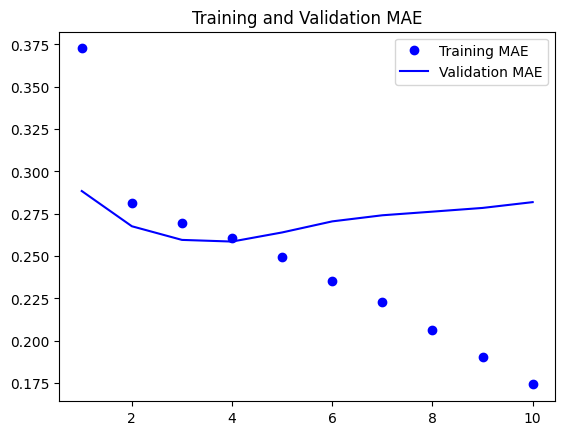

In [57]:
# Plotting MAE like the given example
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()


# **Model 12**

Using 1D Convolution and GRU

In [58]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(inputs)
x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = layers.GRU(32, return_sequences=True)(x)
x = layers.GRU(32, return_sequences=True)(x)
x = layers.GRU(32)(x)
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_cnn_gru.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_cnn_gru.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 225ms/step - loss: 0.1580 - mae: 0.3243 - val_loss: 0.1038 - val_mae: 0.2802
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0909 - mae: 0.2600 - val_loss: 0.1025 - val_mae: 0.2792
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0896 - mae: 0.2580 - val_loss: 0.1013 - val_mae: 0.2783
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0886 - mae: 0.2566 - val_loss: 0.1004 - val_mae: 0.2774
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0878 - mae: 0.2555 - val_loss: 0.0996 - val_mae: 0.2767
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0872 - mae: 0.2545 - val_loss: 0.0989 - val_mae: 0.2760
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0867 - mae: 0.2538 - val_loss: 0.0984 - val_mae: 0.2754
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0863 - mae: 0.2533 - val_loss: 0.0979 - val_mae: 0.2749
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0

**Plotting results**



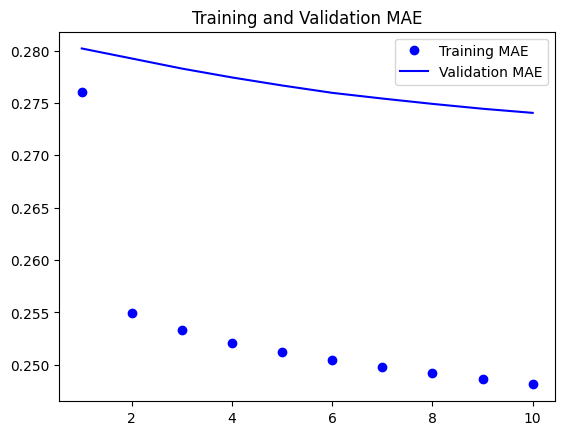

In [59]:
# Plotting MAE like the given example
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

# **Model 13**

Using 1D Convolution, LSTM and Dropout

In [60]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(inputs)
x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = layers.LSTM(32, return_sequences=True)(x)
x = layers.Dropout(0.5)(x)
x = layers.LSTM(32)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_cnn_lstm_dropout.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_cnn_lstm_dropout.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 0.2069 - mae: 0.3699 - val_loss: 0.0799 - val_mae: 0.2449
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.1178 - mae: 0.2904 - val_loss: 0.0839 - val_mae: 0.2506
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.1106 - mae: 0.2871 - val_loss: 0.0793 - val_mae: 0.2435
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.1158 - mae: 0.2938 - val_loss: 0.0807 - val_mae: 0.2460
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.1036 - mae: 0.2777 - val_loss: 0.0794 - val_mae: 0.2430
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.1136 - mae: 0.2913 - val_loss: 0.0798 - val_mae: 0.2421
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.1076 - mae: 0.2831 - val_loss: 0.0807 - val_mae: 0.2457
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.1074 - mae: 0.2832 - val_loss: 0.0804 - val_mae: 0.2452
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.

**Plotting results**



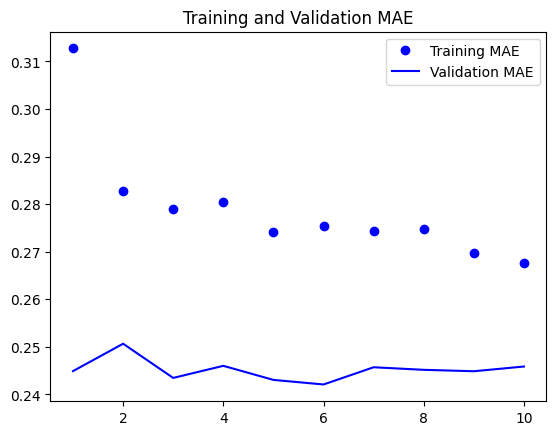

In [61]:
# Plotting MAE like the given example
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

# **Model 14**

Using 1D Convolution, Simple RNN and Dropout

In [62]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
x = layers.Dropout(0.5)(x)
x = layers.SimpleRNN(16)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_cnn_rnn_dropout.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_cnn_rnn_dropout.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.0188 - mae: 0.7912 - val_loss: 0.2695 - val_mae: 0.4149
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.7926 - mae: 0.7173 - val_loss: 0.1859 - val_mae: 0.3452
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.6862 - mae: 0.6571 - val_loss: 0.1380 - val_mae: 0.3048
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.5625 - mae: 0.5957 - val_loss: 0.1243 - val_mae: 0.2885
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.5392 - mae: 0.5822 - val_loss: 0.1204 - val_mae: 0.2759
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.4134 - mae: 0.5213 - val_loss: 0.1064 - val_mae: 0.2650
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.3249 - mae: 0.4589 - val_loss: 0.0954 - val_mae: 0.2618
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.2473 - mae: 0.4017 - val_loss: 0.0890 - val_mae: 0.2513
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.248

**Plotting results**



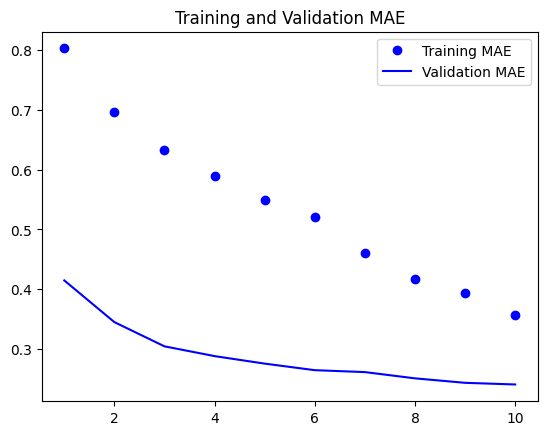

In [63]:
# Plotting MAE like the given example
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

# **Model 15**

Using 1D Convolution, GRU and Dropout



In [64]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(inputs)
x = layers.GRU(32, return_sequences=True)(x)
x = layers.Dropout(0.5)(x)
x = layers.GRU(32)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_cnn_gru_dropout.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_cnn_gru_dropout.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - loss: 0.2494 - mae: 0.4003 - val_loss: 0.0804 - val_mae: 0.2458
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.1163 - mae: 0.2802 - val_loss: 0.0808 - val_mae: 0.2465
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.1072 - mae: 0.2767 - val_loss: 0.0814 - val_mae: 0.2469
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.1030 - mae: 0.2738 - val_loss: 0.0848 - val_mae: 0.2499
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0991 - mae: 0.2683 - val_loss: 0.0807 - val_mae: 0.2461
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - loss: 0.0961 - mae: 0.2672 - val_loss: 0.0801 - val_mae: 0.2453
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1013 - mae: 0.2721 - val_loss: 0.0806 - val_mae: 0.2460
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0935 - mae: 0.2603 - val_loss: 0.0807 - val_mae: 0.2457
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.

**Plotting results**



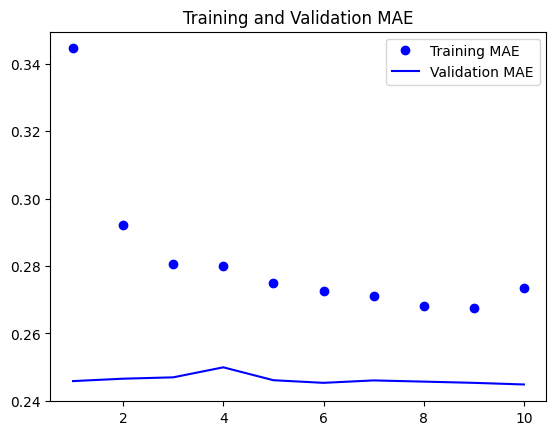

In [68]:
# Plotting MAE like the given example
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

# **Model 16**

Use Bidirectional GRU layers and Dropout




In [69]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.GRU(16, return_sequences=True))(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Bidirectional(layers.GRU(16, return_sequences=True))(x)
x = layers.Dropout(0.5)(x)
x = layers.Bidirectional(layers.GRU(16))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirectional_gru.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_bidirectional_gru.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 389ms/step - loss: 0.2520 - mae: 0.4007 - val_loss: 0.0800 - val_mae: 0.2430
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - loss: 0.1477 - mae: 0.3157 - val_loss: 0.0802 - val_mae: 0.2441
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - loss: 0.1300 - mae: 0.2982 - val_loss: 0.0808 - val_mae: 0.2451
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.1322 - mae: 0.3083 - val_loss: 0.0808 - val_mae: 0.2454
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 0.1239 - mae: 0.2946 - val_loss: 0.0821 - val_mae: 0.2471
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - loss: 0.1167 - mae: 0.2859 - val_loss: 0.0815 - val_mae: 0.2469
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.1237 - mae: 0.2944 - val_loss: 0.0845 - val_mae: 0.2505
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.1113 - mae: 0.2816 - val_loss: 0.0821 - val_mae: 0.2481
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - los

**Plotting results**



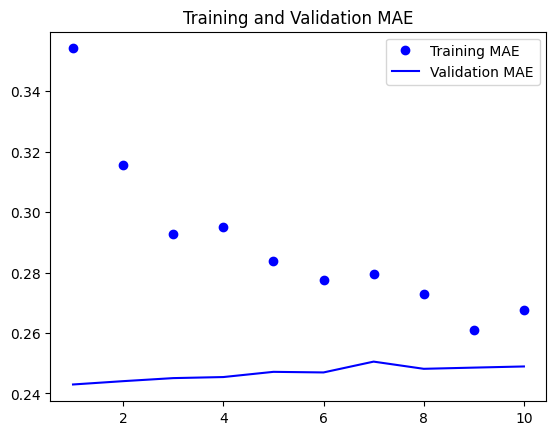

In [70]:
# Plotting MAE like the given example
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

In this project, several RNN-based architectures were tested for weather time-series forecasting, including simple RNNs, GRUs, and LSTMs combined with 1D Convolution and Dropout layers. Among all models, Model 2 (LSTM model with three layers and 8 units) achieved the best performance, with a validation MAE of 0.23 and a test MAE of 0.25. This indicates that the LSTM model effectively captured the temporal patterns in the temperature data while maintaining stable accuracy. The results demonstrate that LSTM networks perform well for sequential weather prediction tasks, as they can remember long-term dependencies better than simple RNN or GRU models.